In [0]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt


In [12]:
## 보통 문장 -> 문장 번역은 
## 단어별로 word embedding을 해야하는데 
## 이번건 단어 -> 단어 임으로 char 별 임베딩 ㄱ 
## 영어로만 하는거여서 256 size  ascisize

vocab_size = 256
## 원문과 변역문을 아크시 코드의 배열로 정의하고 tensor로 바꾸기 
x_ = list(map(ord,"hello"))
y_ = list(map(ord,"hola"))
print("hello ->",x_)
print("hola -> ",y_)
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

hello -> [104, 101, 108, 108, 111]
hola ->  [104, 111, 108, 97]


In [0]:
class seq2seq(nn.Module):
  def __init__(self,vocab_size,hidden_size):
    super(seq2seq,self).__init__()
    self.n_layers = 1
    self.hidden_size = hidden_size
    ##임베팅함수 정의  hidden_size를 임베딩된 토큰의 차원값으로 정의 햇다 그냥 
    self.embedding = nn.Embedding(vocab_size,hidden_size)
    self.encoder = nn.GRU(hidden_size,hidden_size)
    self.decoder = nn.GRU(hidden_size,hidden_size)

    ## decoder가 번역문의 다음토큰을 예상해 내는 작은 신경망
    self.project = nn.Linear(hidden_size,vocab_size)

  def forward(self,inputs,targets):
    ##인코더의 첫번째 은닉벡터 정의하고 
    inital_state = self._init_state()
    ## input 모든 단어를 임베딩 한다 
    embedding = self.embedding(inputs).unsqueeze(1)

    encoder_output ,encoder_state = self.encoder(embedding,inital_state)
    decoder_state = encoder_state
    decoder_input = torch.LongTensor([0]) ## 시작이라는 것만 알려주기위해 그냥 만든것
    outputs = []

    for i in range(targets.size()[0]):
      ## h를 통해 o를 예측 -> l을 예측 
      decoder_input = self.embedding(decoder_input).unsqueeze(1)
      decoder_output, decoder_state = self.decoder(decoder_input,decoder_state)
      
      ##decoder 예측값을 다시 디코더 모델에 입력
      ##decoder 출력값으로 다음 글자 예측 
      projection=self.project(decoder_output)
      outputs.append(projection)

      ## 더치포싱 방식 == 학습이 아직 되지 않은 상태의 모델은 잘못된 예측 토큰을 입력으로 
      ## 사용활 확률이 높다 -> 학습이 뎌뎌 짐 
      ## 티처 포싱 = 학습시 실제 번역문의 토큰을 디코더의 전 출력값 대신 입력으로 사용해 학습을 가속
      ## 티처포싱을 이용한 디코더 입력 갱신
      decoder_input = torch.LongTensor([targets[i]])
    
    outputs = torch.stack(outputs).squeeze()
    return outputs

  def _init_state(self,batch_size = 1):
    ## parameter함수는 nn.module의 가중치 정보들을 반복자 형태로 반환 
    ## 이 반복자가 생성하는 원소들은 각각 실제 신경망의 가중치 텐서(.data)를 지닌 객체들 

    weight = next(self.parameters()).data ## -> nn.gru 모듈의 첫번째 가중치 텐서를 추출한다 
    ## new() 호출하여 모델으 ㅣ가중치와 같은 모양인 텐서로 바꾼후 zero_()를 호출하여 0으로 초기화 
    return weight.new(self.n_layers,batch_size,self.hidden_size).zero_()


In [0]:
seq2seq_model = seq2seq(vocab_size,16)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq_model.parameters(),lr=0.001)


 반복 : 0 error : 0.08767209202051163
['h', 'o', 'l', 'a']

 반복 : 100 error : 0.06602457165718079
['h', 'o', 'l', 'a']

 반복 : 200 error : 0.052076756954193115
['h', 'o', 'l', 'a']

 반복 : 300 error : 0.042391687631607056
['h', 'o', 'l', 'a']

 반복 : 400 error : 0.035311825573444366
['h', 'o', 'l', 'a']

 반복 : 500 error : 0.029937908053398132
['h', 'o', 'l', 'a']

 반복 : 600 error : 0.025739360600709915
['h', 'o', 'l', 'a']

 반복 : 700 error : 0.022382579743862152
['h', 'o', 'l', 'a']

 반복 : 800 error : 0.019648350775241852
['h', 'o', 'l', 'a']

 반복 : 900 error : 0.017386071383953094
['h', 'o', 'l', 'a']


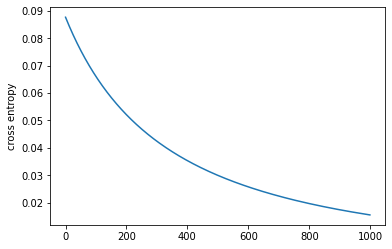

In [30]:
log=[]
for i in range(1000):
  prediction = seq2seq_model(x,y)
 
  loss = criterion(prediction,y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  loss_val=loss.data
  log.append(loss_val)
  if i %100 == 0:
    print("\n 반복 : {} error : {}".format(i,loss_val.item()))
    _, top1 = prediction.data.topk(1,1)
    print([chr(c) for c in top1.squeeze().numpy().tolist()])

plt.plot(log)
plt.ylabel('cross entropy')
plt.show()
